In [1]:
!python --version

Python 3.8.12


# <span style="font-family:AppleGothic; font-weight:bolder"><a href="https://dacon.io/competitions/official/235901/overview/description">🚙 DACON-중고차 가격 예측 경진대회</a></span>

<span style="font-family:AppleGothic; font-weight: bolder;">Data Description</span>

- **id** : 샘플 아이디

- **title** : 제조사 모델명

- **odometer** : 주행 거리

- **location** : 판매처(나이지리아 도시)

- **isimported** : 현지 사용 여부

- **engine** : 엔진 종류

- **transmission** : 트랜스미션 종류

- **fuel** : 연료 종류

- **paint** : 페인트 색상

- **year** : 제조년도

- **target** : 자동차 가격

In [2]:
# 라이브러리 불러오기
import os
import platform

import re

import warnings
warnings.filterwarnings(action = "ignore")

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
%matplotlib inline

In [3]:
# 옵션 지정
if platform.system() == "Windows":
    plt.rcParams["font.family"] = "Malgun Gothic"
else:
    plt.rcParams["font.family"] = "AppleGothic"

plt.rcParams["axes.unicode_minus"] = False
pd.set_option("display.max_columns", None)

# <span style="color:Brown; font-family:AppleGothic; font-weight:bolder">1. Data load</span>

---

In [4]:
# 학습데이터 불러오기
origin_train = pd.read_csv("./data/train.csv")
print("Shape of train data :", origin_train.shape, "\n")

# 평가데이터 불러오기
origin_test = pd.read_csv("./data/test.csv")
print("Shape of test data :", origin_test.shape, "\n")

display(origin_train.head())
display(origin_test.head())

Shape of train data : (1015, 11) 

Shape of test data : (436, 10) 



,id,title,odometer,location,isimported,engine,transmission,fuel,paint,year,target
0,0,Toyota RAV 4,18277,Lagos,Foreign Used,4-cylinder(I4),automatic,petrol,Red,2016,13665000
1,1,Toyota Land Cruiser,10,Lagos,New,4-cylinder(I4),automatic,petrol,Black,2019,33015000
2,2,Land Rover Range Rover Evoque,83091,Lagos,Foreign Used,6-cylinder(V6),automatic,petrol,Red,2012,9915000
3,3,Lexus ES 350,91524,Lagos,Foreign Used,4-cylinder(I4),automatic,petrol,Gray,2007,3815000
4,4,Toyota Venza,94177,Lagos,Foreign Used,6-cylinder(V6),automatic,petrol,Red,2010,7385000


,id,title,odometer,location,isimported,engine,transmission,fuel,paint,year
0,0,Mercedes-Benz C 300,1234,Abuja,New,4-cylinder(I4),automatic,petrol,White,2017
1,1,Honda Accord,29938,Abuja,Foreign Used,4-cylinder(I4),automatic,petrol,White,2013
2,2,Mercedes-Benz S 550,87501,Lagos,Foreign Used,4-cylinder(I4),automatic,petrol,Black,2012
3,3,Toyota Sienna,180894,Lagos,Locally used,6-cylinder(V6),automatic,petrol,Dark Grey,2001
4,4,Toyota Hiace,104814,Lagos,Foreign Used,4-cylinder(I4),automatic,petrol,White,2000


- 학습 데이터는 **1,015**개의 관측치와 11개의 변수가 존재한다.

- 평가 데이터는 **415**개의 관측치와 10개의 변수가 존재함을 확인할 수 있다.

- 데이터 일부를 살펴보았을 때, 범주형 변수가 많음을 확인할 수 있다.

# <span style="color:Brown; font-family:AppleGothic; font-weight:bolder">2. Data EDA - 1</span>

---

- 각 변수들을 확인해보고 예측 변수와의 어떤 관계가 있는지 확인해보도록 한다.

In [5]:
# Train data
print("----------Train data Information----------\n")
print(origin_train.info(), "\n")

# Test data
print("----------Test data Information----------\n")
print(origin_test.info())

----------Train data Information----------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1015 entries, 0 to 1014
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            1015 non-null   int64 
 1   title         1015 non-null   object
 2   odometer      1015 non-null   int64 
 3   location      1015 non-null   object
 4   isimported    1015 non-null   object
 5   engine        1015 non-null   object
 6   transmission  1015 non-null   object
 7   fuel          1015 non-null   object
 8   paint         1015 non-null   object
 9   year          1015 non-null   int64 
 10  target        1015 non-null   int64 
dtypes: int64(4), object(7)
memory usage: 87.4+ KB
None 

----------Test data Information----------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 436 entries, 0 to 435
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id      

- 우선, 학습 데이터와 평가 데이터의 정보를 간단하게 확인해보도록 한다.

- 시각화를 통해 결측치의 정보를 확인할 수 있지만, 위의 정보를 통해 두 데이터의 모든 변수에 결측치가 없음을 확인할 수 있으므로 생략하도록 한다.

- **id, target** 두 변수를 제외하고 **2**개의 숫자형 변수와 **7**개의 범주형 변수로 이루어져 있음을 확인할 수 있다.

## <span style="color:Chocolate; font-family:AppleGothic; font-weight:bolder">2.1 Target variable</span>

- 현재 예측 변수는 치우침의 정도가 심하며 로그 변환한 변수를 만들어주도록 한다.

In [6]:
print("Shape of train data *Before Create* :", origin_train.shape, "\n")

# Log Transformation
origin_train["log_target"] = np.log(origin_train["target"])
print("Shape of train data *After Create* :", origin_train.shape, "\n")
display(origin_train.head())

Shape of train data *Before Create* : (1015, 11) 

Shape of train data *After Create* : (1015, 12) 



,id,title,odometer,location,isimported,engine,transmission,fuel,paint,year,target,log_target
0,0,Toyota RAV 4,18277,Lagos,Foreign Used,4-cylinder(I4),automatic,petrol,Red,2016,13665000,16.430348
1,1,Toyota Land Cruiser,10,Lagos,New,4-cylinder(I4),automatic,petrol,Black,2019,33015000,17.312473
2,2,Land Rover Range Rover Evoque,83091,Lagos,Foreign Used,6-cylinder(V6),automatic,petrol,Red,2012,9915000,16.109559
3,3,Lexus ES 350,91524,Lagos,Foreign Used,4-cylinder(I4),automatic,petrol,Gray,2007,3815000,15.154451
4,4,Toyota Venza,94177,Lagos,Foreign Used,6-cylinder(V6),automatic,petrol,Red,2010,7385000,15.814961


In [7]:
# 예측 변수의 왜도와 첨도
origin_skew = round(origin_train["target"].skew(), 3)
origin_kurt = round(origin_train["target"].kurtosis(), 3)

# 로그 변환을 수행한 예측 변수의 왜도와 첨도
log_skew = round(origin_train["log_target"].skew(), 3)
log_kurt = round(origin_train["log_target"].kurtosis(), 3)

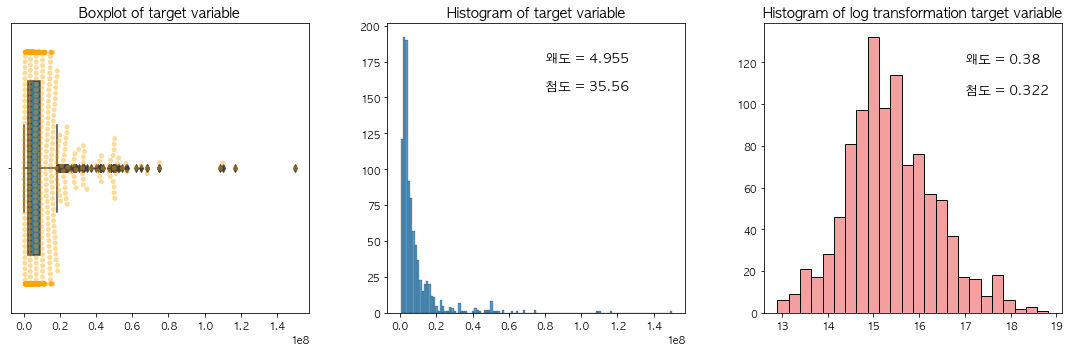

In [8]:
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (15, 5))

# Box & Swarm plot
sns.boxplot(origin_train["target"], width = 0.6, ax = axes[0])
sns.swarmplot(origin_train["target"], color = "orange", alpha = 0.4, ax = axes[0])
axes[0].set_title("Boxplot of target variable", fontsize = 14)

# Histogram
sns.histplot(origin_train["target"], ax = axes[1])
axes[1].set_title("Histogram of target variable", fontsize = 14)
axes[1].text(x = 80000000, y = 175, s = "왜도 = {}".format(origin_skew), fontsize = 13)
axes[1].text(x = 80000000, y = 155, s = "첨도 = {}".format(origin_kurt), fontsize = 13)

# Log Transformation
sns.histplot(np.log(origin_train["target"]), color = "lightcoral", ax = axes[2])
axes[2].set_title("Histogram of log transformation target variable", fontsize = 14)
axes[2].text(x = 17, y = 120, s = "왜도 = {}".format(log_skew), fontsize = 13)
axes[2].text(x = 17, y = 105, s = "첨도 = {}".format(log_kurt), fontsize = 13)

for index in [0, 1, 2]:
    axes[index].set_xlabel("")
    axes[index].set_ylabel("")

fig.tight_layout(w_pad = 5)

- 로그 변환을 수행하기 전의 예측 변수를 살펴보면 왼쪽으로 매우 치우쳐져 있음을 확인할 수 있다.

- 또한, 왜도의 값이 그렇게 크지는 않지만 첨도의 값이 약 **35.56**으로 매우 크다는 사실을 확인할 수 있다.

- 반면에 로그 변환을 수행한 예측 변수는 왜도, 첨도의 값이 낮고 정규분포에 가깝다는 것을 확인할 수 있다.

- **따라서, 로그 변환을 수행한 변수를 사용해주도록 한다.**

## <span style="color:Chocolate; font-family:AppleGothic; font-weight:bolder">2.2 Title</span>

- **title** 변수는 **제조사 모델명**을 나타내며, 학습 데이터와 평가 데이터의 제조사 모델명이 모두 일치하는지 확인해보도록 하자.

In [9]:
print("Length of title in train data :", len(origin_train["title"].unique()), "\n")
print("Length of title in test data :", len(origin_test["title"].unique()), "\n")

# 'title' 변수 집합 객체 생성
train_title = set(origin_train["title"])
test_title = set(origin_test["title"])

print("학습 데이터에만 존재하는 제조사 모델명 개수 :", len(train_title.difference(test_title)), "\n")
print("평가 데이터에만 존재하는 제조사 모델명 개수 :", len(test_title.difference(train_title)))

Length of title in train data : 203 

Length of title in test data : 124 

학습 데이터에만 존재하는 제조사 모델명 개수 : 116 

평가 데이터에만 존재하는 제조사 모델명 개수 : 37


- 학습 데이터에 존재하는 제조사 모델명 개수는 203개이며, 평가 데이터에 존재하는 제조사 모델명 개수는 124개이다.

- 학습 데이터에만 존재하는 제조 모델명 개수는 116개이며, 평가 데이터에만 존재하는 제조사 모델명 개수는 37개이다.

- 학습 데이터에 존재하지 않는 제조사 모델명이 평가 데이터에 존재하기 때문에 **title** 변수를 그대로 사용하기에는 부적절하다.

- 또한, 해당 변수를 그대로 사용하는 경우 **202**개의 가변수를 만들어줘야 한다.<br><br>

- **title** 변수를 살펴보면 앞부분은 제조사를 나타내는 것을 확인할 수 있다.

- 따라서, 모델명은 제거하고 제조사만 나타낼 수 있도록 처리해주도록 한다.

- 우선, **'공백'** 으로 분할한 후 첫번째 값을 가져오고, **'-'** 기호로 분할한 후 첫번째 값을 가져온다.

- 마지막으로 모든 문자열을 소문자로 바꿔주도록 한다.

### <span style="color:GoldenRod; font-family:AppleGothic; font-weight:bolder">2.2.1 제조사 추출 함수 생성</span>

In [10]:
# 'title' 변수에서 제조사만 추출하는 함수 생성
def title_extract(text):
    
    # '공백'으로 분할 후, 첫번째 값 추출
    text = text.split(" ")[0]
    
    # '-' 기호로 분할 후, 첫번째 값 추출
    text = text.split("-")[0]
    
    # 반환할때는 소문자로 변환
    return text.lower()

In [11]:
print("Shape of train data *Before Create* :", origin_train.shape, "\n")
print("Shape of test data *Before Create* :", origin_test.shape, "\n")

# 함수 적용
origin_train["main_title"] = origin_train["title"].apply(title_extract)
origin_test["main_title"] = origin_test["title"].apply(title_extract)

print("Shape of train data *After Create* :", origin_train.shape, "\n")
print("Shape of test data *After Create* :", origin_test.shape, "\n")

display(origin_train.head(3))
display(origin_test.head(3))

Shape of train data *Before Create* : (1015, 12) 

Shape of test data *Before Create* : (436, 10) 

Shape of train data *After Create* : (1015, 13) 

Shape of test data *After Create* : (436, 11) 



,id,title,odometer,location,isimported,engine,transmission,fuel,paint,year,target,log_target,main_title
0,0,Toyota RAV 4,18277,Lagos,Foreign Used,4-cylinder(I4),automatic,petrol,Red,2016,13665000,16.430348,toyota
1,1,Toyota Land Cruiser,10,Lagos,New,4-cylinder(I4),automatic,petrol,Black,2019,33015000,17.312473,toyota
2,2,Land Rover Range Rover Evoque,83091,Lagos,Foreign Used,6-cylinder(V6),automatic,petrol,Red,2012,9915000,16.109559,land


,id,title,odometer,location,isimported,engine,transmission,fuel,paint,year,main_title
0,0,Mercedes-Benz C 300,1234,Abuja,New,4-cylinder(I4),automatic,petrol,White,2017,mercedes
1,1,Honda Accord,29938,Abuja,Foreign Used,4-cylinder(I4),automatic,petrol,White,2013,honda
2,2,Mercedes-Benz S 550,87501,Lagos,Foreign Used,4-cylinder(I4),automatic,petrol,Black,2012,mercedes


In [12]:
print("Length of main title in train data :", len(origin_train["main_title"].unique()), "\n")
print("Length of main title in test data :", len(origin_test["main_title"].unique()))

Length of main title in train data : 39 

Length of main title in test data : 28


- 위의 과정을 거쳤더니 제조사의 개수가 학습 데이터는 39개로, 평가 데이터는 28개로 줄어들었음을 확인할 수 있다.

- 줄어들었다 하더라도 여전히 많은 개수이기 때문에 시각화를 통해 살펴보도록 한다.

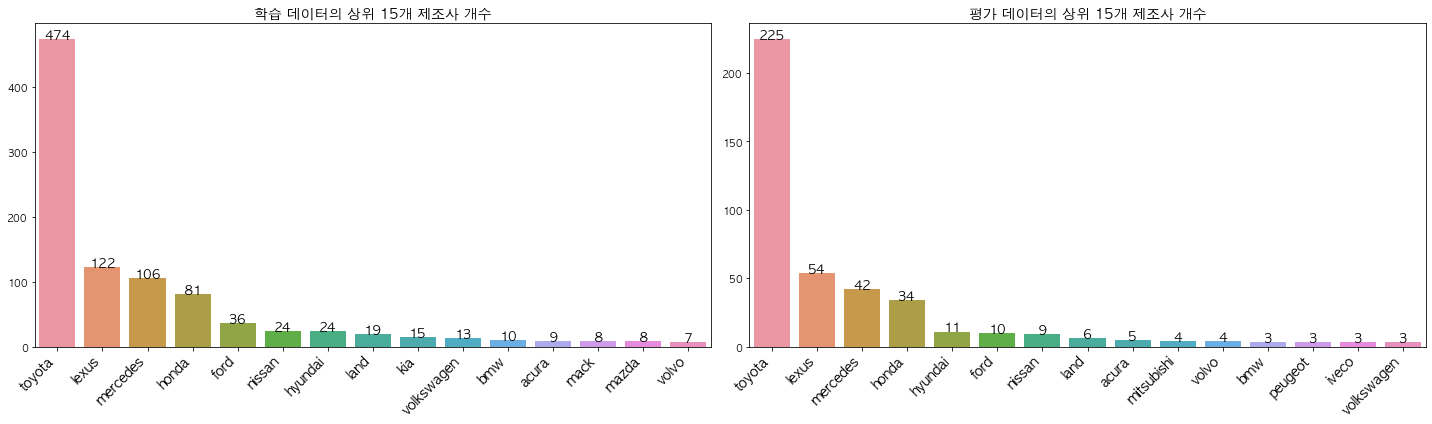

In [13]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 6))

# Train data 상위 15개 확인
plot_data = pd.DataFrame(origin_train["main_title"].value_counts().head(15))

sns.barplot(x = plot_data.index, y = "main_title", data = plot_data, ax = axes[0])
axes[0].set_xticklabels(labels = plot_data.index, fontsize = 14)
axes[0].set_title("학습 데이터의 상위 15개 제조사 개수", fontsize = 14)

# Test data 상위 15개 확인
plot_data = pd.DataFrame(origin_test["main_title"].value_counts().head(15))

sns.barplot(x = plot_data.index, y = "main_title", data = plot_data, ax = axes[1])
axes[1].set_xticklabels(labels = plot_data.index, fontsize = 14)
axes[1].set_title("평가 데이터의 상위 15개 제조사 개수", fontsize = 14)

for index in [0, 1]:
    axes[index].set_ylabel("")
    
    for rect in axes[index].patches:
        axes[index].text(rect.get_x() + rect.get_width() / 2, rect.get_height(), int(rect.get_height()), ha = "center", fontsize = 13)

fig.autofmt_xdate(rotation = 45)
fig.tight_layout()

- 학습 데이터와 평가 데이터 모두 **toyota** 제조사가 가장 많이 등장함을 알 수 있다.

- 또한, 상위 4개 브랜드는 많이 등장하지만, 그 외의 제조사는 등장 횟수가 매우 적음을 알 수 있다.

- **따라서 해당 변수는 추후에 범주를 묶어줄 필요성이 있는 것으로 판단된다.**

## <span style="color:Chocolate; font-family:AppleGothic; font-weight:bolder">2.3 Odometer</span>

- **Odometer** 변수는 해당 중고차의 주행거리를 나타내는 변수이다.

- **Odometer** 변수도 편차가 클 것으로 판단되기 때문에 로그 변환을 수행해주도록 한다.

In [14]:
print("Shape of train data *Before Create* :", origin_train.shape, "\n")
print("Shape of test data *Before Create* :", origin_test.shape, "\n")

# Log Transformation
origin_train["log_odometer"] = np.log1p(origin_train["odometer"])
origin_test["log_odometer"] = np.log1p(origin_test["odometer"])

print("Shape of train data *After Create* :", origin_train.shape, "\n")
print("Shape of test data *After Create* :", origin_test.shape, "\n")

display(origin_train.head(3))
display(origin_test.head(3))

Shape of train data *Before Create* : (1015, 13) 

Shape of test data *Before Create* : (436, 11) 

Shape of train data *After Create* : (1015, 14) 

Shape of test data *After Create* : (436, 12) 



,id,title,odometer,location,isimported,engine,transmission,fuel,paint,year,target,log_target,main_title,log_odometer
0,0,Toyota RAV 4,18277,Lagos,Foreign Used,4-cylinder(I4),automatic,petrol,Red,2016,13665000,16.430348,toyota,9.813453
1,1,Toyota Land Cruiser,10,Lagos,New,4-cylinder(I4),automatic,petrol,Black,2019,33015000,17.312473,toyota,2.397895
2,2,Land Rover Range Rover Evoque,83091,Lagos,Foreign Used,6-cylinder(V6),automatic,petrol,Red,2012,9915000,16.109559,land,11.327704


,id,title,odometer,location,isimported,engine,transmission,fuel,paint,year,main_title,log_odometer
0,0,Mercedes-Benz C 300,1234,Abuja,New,4-cylinder(I4),automatic,petrol,White,2017,mercedes,7.118826
1,1,Honda Accord,29938,Abuja,Foreign Used,4-cylinder(I4),automatic,petrol,White,2013,honda,10.306917
2,2,Mercedes-Benz S 550,87501,Lagos,Foreign Used,4-cylinder(I4),automatic,petrol,Black,2012,mercedes,11.379417


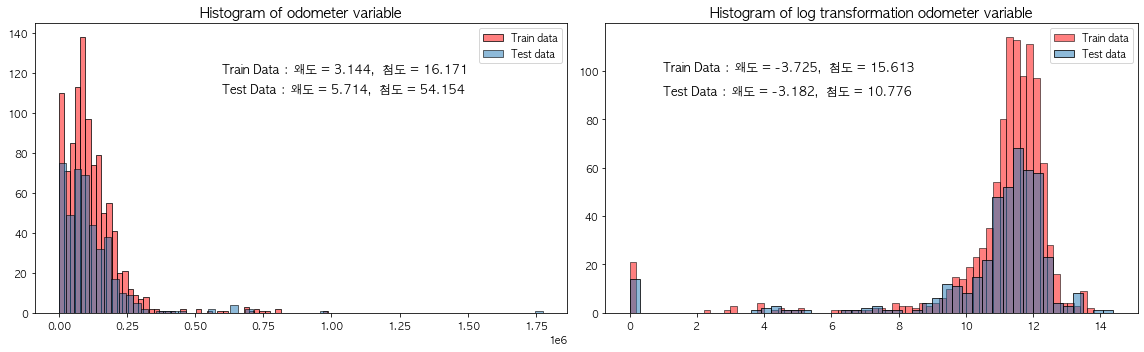

In [15]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (16, 5))

# Original Odometer
sns.histplot(origin_train["odometer"], color = "red", alpha = 0.5, label = "Train data", ax = axes[0])
sns.histplot(origin_test["odometer"], alpha = 0.5, label = "Test data", ax = axes[0])
axes[0].text(
    x = 600000,
    y = 120,
    s = "Train Data : 왜도 = {:.3f},\t 첨도 = {:.3f}".format(origin_train["odometer"].skew(), origin_train["odometer"].kurtosis()),
    fontsize = 12)
axes[0].text(
    x = 600000,
    y = 110,
    s = "Test Data : 왜도 = {:.3f},\t 첨도 = {:.3f}".format(origin_test["odometer"].skew(), origin_test["odometer"].kurtosis()),
    fontsize = 12)
axes[0].set_title("Histogram of odometer variable", fontsize = 14)
axes[0].legend()

# Log Transformation Odometer
sns.histplot(origin_train["log_odometer"], color = "red", alpha = 0.5, label = "Train data", ax = axes[1])
sns.histplot(origin_test["log_odometer"], alpha = 0.5, label = "Test data", ax = axes[1])
axes[1].text(
    x = 1,
    y = 100,
    s = "Train Data : 왜도 = {:.3f},\t 첨도 = {:.3f}".format(origin_train["log_odometer"].skew(), origin_train["log_odometer"].kurtosis()),
    fontsize = 12)
axes[1].text(
    x = 1,
    y = 90,
    s = "Test Data : 왜도 = {:.3f},\t 첨도 = {:.3f}".format(origin_test["log_odometer"].skew(), origin_test["log_odometer"].kurtosis()),
    fontsize = 12)
axes[1].set_title("Histogram of log transformation odometer variable", fontsize = 14)
axes[1].legend()

for index in [0, 1]:
    axes[index].set_xlabel("")
    axes[index].set_ylabel("")

fig.tight_layout()

- 우선 학습 데이터와 평가 데이터의 **odometer** 변수는 왼쪽으로 치우쳐져 있음을 확인할 수 있다.

- 학습 데이터의 첨도에 비해 평가 데이터의 첨도가 매우 큼을 확인할 수 있다.

- 로그 변환을 수행해도 오른쪽으로 치우쳐질 뿐, 첨도에는 큰 변화가 없는 것을 확인할 수 있다.

- 반면, 평가 데이터에서 로그 변환을 수행했을 때는 첨도가 낮아짐을 확인할 수 있다.

- **따라서 해당 변수는 단순히 로그 변환을 해주기 보다는 다른 변수와의 관계를 찾아서 이상치를 처리해주는 것이 좋을것으로 판단된다.**

## <span style="color:Chocolate; font-family:AppleGothic; font-weight:bolder">2.4 location</span>

- **Location** 변수는 중고차를 판매하고 있는 나이지리아의 도시를 나타낸다.<br><br>

- **Location** 변수를 살펴보면 같은 도시를 나타내는데도 뒤에 `State` 혹은 `공백`이 추가되어 있어 서로 다른 도시로 표시되어 있다.

- 또한, 평가 데이터에서는 `Arepo ogun state` 값이 존재하는데, Arepo는 나이지리아 Ogun State에 위치한 인구 밀집 지역을 나타낸다고 한다.

- 따라서 해당 값을 ogun으로 변환해주도록 한다.

### <span style="color:GoldenRod; font-family:AppleGothic; font-weight:bolder">2.4.1 도시 변환 함수 생성</span>

In [16]:
# 'location' 변수 변환을 수행해주는 함수 생성
def location_transformation(text):
    
    # 우선 모든 값들을 소문자로 변경
    text = text.lower()
    
    # 공백, state, arepo 세가지를 탐지할 수 있는 컴파일 객체 생성
    p = re.compile(" |arepo|state")
    
    # 위의 컴파일 객체를 사용하여 해당하는 문자 제거
    text = p.sub("", text)
    
    return text

In [17]:
print("Shape of train data *Before Create* :", origin_train.shape, "\n")
print("Shape of test data *Before Create* :", origin_test.shape, "\n")

# 함수 적용
origin_train["loc"] = origin_train["location"].apply(location_transformation)
origin_test["loc"] = origin_test["location"].apply(location_transformation)

print("Shape of train data *After Create* :", origin_train.shape, "\n")
print("Shape of test data *After Create* :", origin_test.shape, "\n")

display(origin_train.head(3))
display(origin_test.head(3))

Shape of train data *Before Create* : (1015, 14) 

Shape of test data *Before Create* : (436, 12) 

Shape of train data *After Create* : (1015, 15) 

Shape of test data *After Create* : (436, 13) 



,id,title,odometer,location,isimported,engine,transmission,fuel,paint,year,target,log_target,main_title,log_odometer,loc
0,0,Toyota RAV 4,18277,Lagos,Foreign Used,4-cylinder(I4),automatic,petrol,Red,2016,13665000,16.430348,toyota,9.813453,lagos
1,1,Toyota Land Cruiser,10,Lagos,New,4-cylinder(I4),automatic,petrol,Black,2019,33015000,17.312473,toyota,2.397895,lagos
2,2,Land Rover Range Rover Evoque,83091,Lagos,Foreign Used,6-cylinder(V6),automatic,petrol,Red,2012,9915000,16.109559,land,11.327704,lagos


,id,title,odometer,location,isimported,engine,transmission,fuel,paint,year,main_title,log_odometer,loc
0,0,Mercedes-Benz C 300,1234,Abuja,New,4-cylinder(I4),automatic,petrol,White,2017,mercedes,7.118826,abuja
1,1,Honda Accord,29938,Abuja,Foreign Used,4-cylinder(I4),automatic,petrol,White,2013,honda,10.306917,abuja
2,2,Mercedes-Benz S 550,87501,Lagos,Foreign Used,4-cylinder(I4),automatic,petrol,Black,2012,mercedes,11.379417,lagos


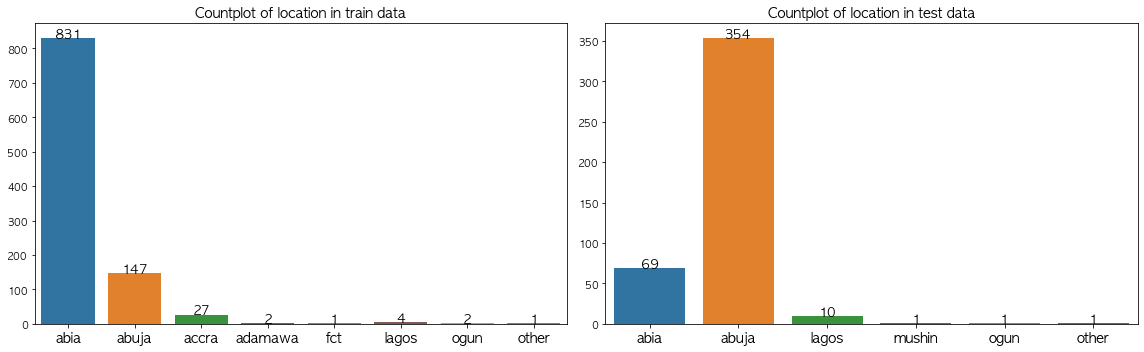

In [18]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (16, 5))

# Train data
sns.countplot(origin_train["loc"], ax = axes[0])
axes[0].set_title("Countplot of location in train data", fontsize = 14)
axes[0].set_xticklabels(labels = np.unique(origin_train["loc"]), fontsize = 14)

# Test data
sns.countplot(origin_test["loc"], ax = axes[1])
axes[1].set_title("Countplot of location in test data", fontsize = 14)
axes[1].set_xticklabels(labels = np.unique(origin_test["loc"]), fontsize = 14)

for index in [0, 1]:
    axes[index].set_xlabel("")
    axes[index].set_ylabel("")
    
    for rect in axes[index].patches:
        axes[index].text(rect.get_x() + rect.get_width() / 2, rect.get_height(), rect.get_height(), ha = "center", fontsize = 13)
    
fig.tight_layout()

- 학습 데이터에서는 **Abia 도시**가 가장 많이 등장하고, 평가 데이터에서는 **Abuja 도시**가 가장 많이 등장한다.

- 학습 데이터와 평가 데이터 모두 대부분 **Abia, Abuja** 도시에서 관측되며, 그 외 도시들은 매우 적게 관측됨을 확인할 수 있다.

- **따라서, Abia, Abuja 도시 외에는 기타 도시로 묶어주는 것이 좋을것으로 판단된다.**

## <span style="color:Chocolate; font-family:AppleGothic; font-weight:bolder">2.5 Isimported</span>

- **Isimported** 변수는 현지 사용 여부를 나타내는 변수이다.

In [19]:
# 'isimported' 변수 오른쪽 공백 제거
origin_train["isimported"] = origin_train["isimported"].apply(lambda x: x.rstrip())
origin_test["isimported"] = origin_test["isimported"].apply(lambda x: x.rstrip())

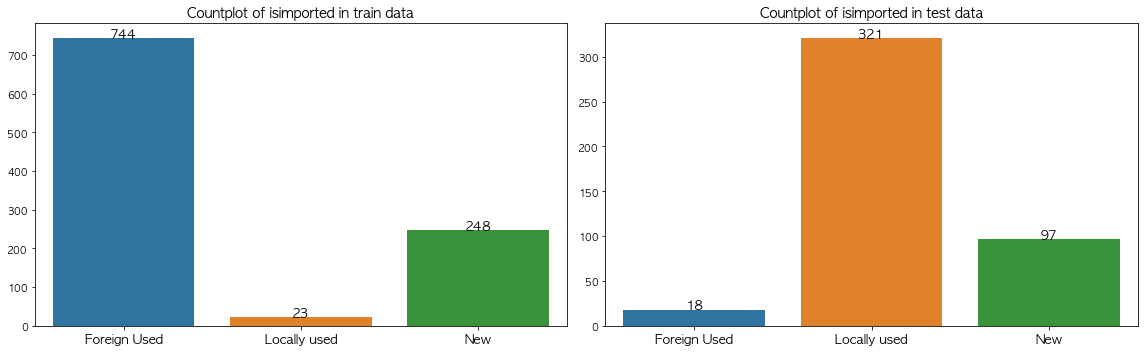

In [20]:
# 시각화
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (16, 5))

# Train data
sns.countplot(origin_train["isimported"], ax = axes[0])
axes[0].set_title("Countplot of isimported in train data", fontsize = 14)

# Test data
sns.countplot(origin_test["isimported"], ax = axes[1])
axes[1].set_title("Countplot of isimported in test data", fontsize = 14)

for index in [0, 1]:
    axes[index].set_xlabel("")
    axes[index].set_ylabel("")
    axes[index].set_xticklabels(np.unique(origin_train["isimported"]), fontsize = 13)
    
    for rect in axes[index].patches:
        axes[index].text(rect.get_x() + rect.get_width() / 2, rect.get_height(), rect.get_height(), ha = "center", fontsize = 13)

fig.tight_layout()

- 학습 데이터에서는 **Foreign Used > New > Locally used** 순으로 관측되며, 평가 데이터에서는 **Locally used > New > Foreign Used** 순으로 관측됨을 확인할 수 있다.

- 학습 데이터에서 **Locally used** 범주가 매우 적게 관측되기 때문에 만약, 세 범주간에 유의미한 차이가 있다면 오버샘플링 방법도 생각해봐야 할 것으로 판단된다.

## <span style="color:Chocolate; font-family:AppleGothic; font-weight:bolder">2.6 Engine</span>

- **Engine** 변수는 엔진 종류를 나타내는 변수이다.<br><br>

- **Engine** 변수의 값의 경우 `2-cylinder(I2)`와 같은 식으로 입력되어 있으며, 괄호안의 값들로 변경해주도록 한다.

In [21]:
# 'engine' 변수 정제
origin_train["engine"] = origin_train["engine"].apply(lambda x: re.search(r"\((.+?)\)", x).group(1))
origin_test["engine"] = origin_test["engine"].apply(lambda x: re.search(r"\((.+?)\)", x).group(1))

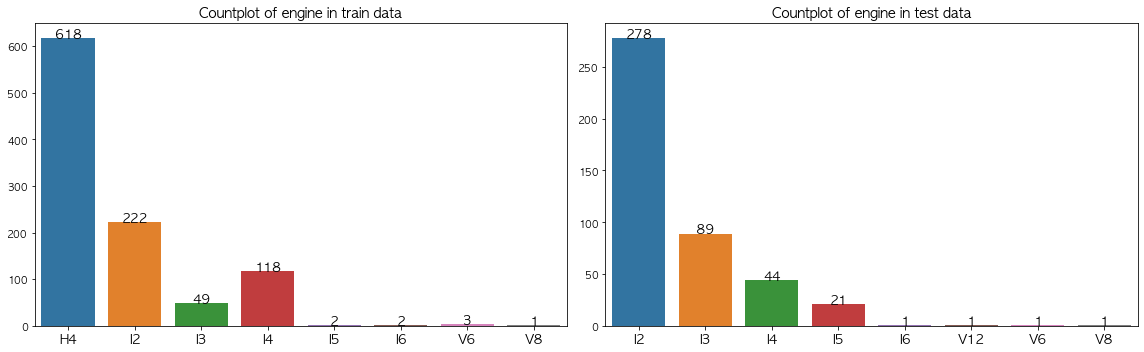

In [22]:
# 시각화
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (16, 5))

# Train data
sns.countplot(origin_train["engine"], ax = axes[0])
axes[0].set_xticklabels(np.unique(origin_train["engine"]), fontsize = 13)
axes[0].set_title("Countplot of engine in train data", fontsize = 14)

# Test data
sns.countplot(origin_test["engine"], ax = axes[1])
axes[1].set_xticklabels(np.unique(origin_test["engine"]), fontsize = 13)
axes[1].set_title("Countplot of engine in test data", fontsize = 14)

for index in [0, 1]:
    axes[index].set_xlabel("")
    axes[index].set_ylabel("")
    
    for rect in axes[index].patches:
        axes[index].text(rect.get_x() + rect.get_width() / 2, rect.get_height(), rect.get_height(), ha = "center", fontsize = 13)

fig.tight_layout()

- 학습 데이터에서는 **H4** 엔진이 가장 많이 등장하고, 평가 데이터에서는 **I2** 엔진이 가장 많이 등장한다.

- 학습 데이터와 평가 데이터에서 등장하는 엔진 비율이 서로 상이하므로, 처리해줄 방법을 생각해봐야 할 필요성이 있다.

## <span style="color:Chocolate; font-family:AppleGothic; font-weight:bolder">2.7 Transmission</span>

- **Transmission** 변수는 변속기 종류를 나타내는 변수이다.<br><br>

- **Transmission** 변수는 따로 처리를 해줘야 하는 작업이 필요하지 않다.

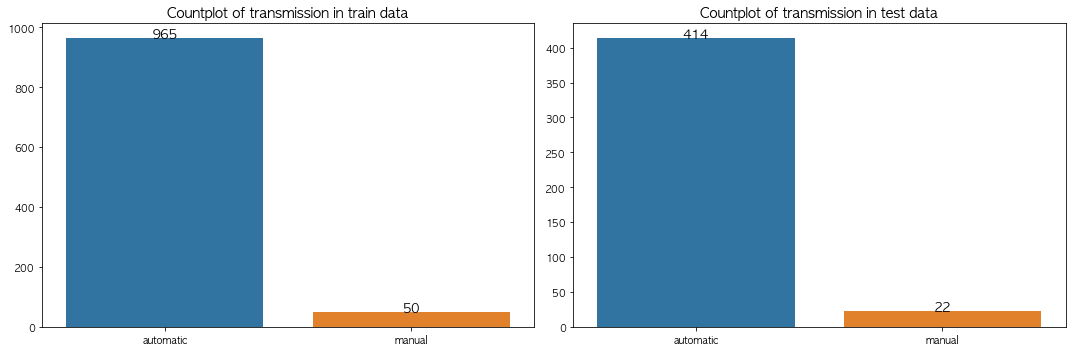

In [23]:
# 시각화
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 5))

# Train data
sns.countplot(origin_train["transmission"], ax = axes[0])
axes[0].set_title("Countplot of transmission in train data", fontsize = 14)

# Test data
sns.countplot(origin_test["transmission"], ax = axes[1])
axes[1].set_title("Countplot of transmission in test data", fontsize = 14)

for index in [0, 1]:
    axes[index].set_xlabel("")
    axes[index].set_ylabel("")
    
    for rect in axes[index].patches:
        axes[index].text(rect.get_x() + rect.get_width() / 2, rect.get_height(), rect.get_height(), ha = "center", fontsize = 13)

fig.tight_layout()

- 학습 데이터와 평가 데이터 모두 변속기 종류는 **자동**이 많음을 확인할 수 있다.

- 두 범주간의 유의미한 차이가 발견되지 않는다면 삭제해주도록 하고, 만약 차이가 있다면 오버샘플링을 해주는 것이 적절하다고 생각된다.

## <span style="color:Chocolate; font-family:AppleGothic; font-weight:bolder">2.8 Fuel</span>

- **Fuel** 변수는 연료의 종류를 나타내는 변수이다.<br><br>

- **Fuel** 변수도 따로 전처리 작업이 필요하지 않다.

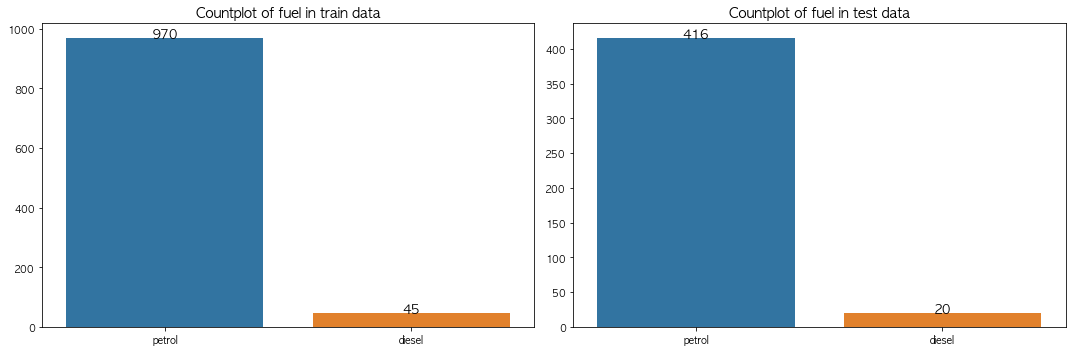

In [24]:
# 시각화
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 5))

# Train data
sns.countplot(origin_train["fuel"], ax = axes[0])
axes[0].set_title("Countplot of fuel in train data", fontsize = 14)

# Test data
sns.countplot(origin_test["fuel"], ax = axes[1])
axes[1].set_title("Countplot of fuel in test data", fontsize = 14)

for index in [0, 1]:
    axes[index].set_xlabel("")
    axes[index].set_ylabel("")
    
    for rect in axes[index].patches:
        axes[index].text(rect.get_x() + rect.get_width() / 2, rect.get_height(), rect.get_height(), ha = "center", fontsize = 13)

fig.tight_layout()

- 학습 데이터와 평가 데이터 모두 **petrol** 종류가 많음을 확인할 수 있다.

## <span style="color:Chocolate; font-family:AppleGothic; font-weight:bolder">2.9 Paint</span>

- **Paint** 변수는 차량의 페인트 색상을 나타내는 변수이다.

In [25]:
# 학습 데이터
print(np.unique(origin_train["paint"]))

[' Black' ' Black/Red' 'Ash' 'Ash and black' 'BLACK' 'Beige' 'Black'
 'Black ' 'Black and silver' 'Black sand pearl' 'Black.' 'Blue' 'Blue '
 'Brown' 'Cream' 'Cream ' 'DARK GREY' 'Dark Ash' 'Dark Blue' 'Dark Green'
 'Dark Grey' 'Dark ash' 'Dark blue ' 'Dark gray' 'Dark silver '
 'Deep Blue' 'Deep blue' 'GOLD' 'Gery' 'Gold' 'Gold ' 'Gray' 'Gray '
 'Green' 'Green ' 'Grey' 'Grey ' 'Ink blue' 'Light Gold' 'Light blue'
 'Light silver ' 'Magnetic Gray' 'Magnetic Gray Metallic' 'Maroon'
 'Midnight Black Metal' 'Milk' 'Navy blue' 'Off white' 'Off white l'
 'Pale brown' 'Purple' 'Red' 'Redl' 'SILVER' 'Silver' 'Silver '
 'Silver/grey' 'Sky blue' 'Skye blue' 'Sliver' 'Super White' 'WHITE'
 'WINE' 'Whine ' 'White' 'White ' 'White orchild pearl' 'Wine' 'Yellow'
 'blue' 'green' 'orange' 'red' 'white' 'white-blue' 'yellow']


In [26]:
# 평가 데이터
print(np.unique(origin_test["paint"]))

['  Brown' 'Ash' 'BLACK' 'Beige' 'Blac' 'Black' 'Black ' 'Blue' 'Blue '
 'Brown' 'Classic Silver Met(1F7)' 'Cream' 'Cream ' 'Dark Ash' 'Dark Blue'
 'Dark Green' 'Dark Grey' 'Dark blue ' 'GOLD' 'Gold' 'Gold ' 'Golf' 'Gray'
 'Green' 'Green ' 'Grey' 'Grey ' 'Grey and black' 'Indigo ink pearl'
 'Light Grey' 'Maroon' 'Mint green' 'Navy blue' 'Red' 'Silver' 'Silver '
 'Sliver' 'Sliver ' 'White' 'White and green' 'Wine' 'Yellow' 'black'
 'blue' 'green' 'white']


- 학습 데이터와 평가 데이터의 **paint** 변수의 고유값을 확인햐보면 매우 많은 색상이 존재함을 확인할 수 있다.

- 하지만 자세히 보면 같은 색상인데도 오타 혹은 공백 등으로 잘못 기입되어 있어서 서로 다른 색상으로 분류되어 있다.

- **Paint** 변수는 아래의 과정에서 예측 변수와 살펴보며 정제해주도록 한다.

## <span style="color:Chocolate; font-family:AppleGothic; font-weight:bolder">2.10 Year</span>

In [28]:
# 학습 데이터
print(np.unique(origin_train["year"]))

[1217 1218 1980 1982 1985 1991 1994 1995 1996 1997 1998 1999 2000 2001
 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015
 2016 2017 2018 2019 2020]


In [29]:
# 평가 데이터
print(np.unique(origin_test["year"]))

[1324 1726 1987 1993 1994 1996 1997 1998 1999 2000 2001 2002 2003 2004
 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018
 2019 2020 2626]


- 위의 결과를 보면 학습 데이터에는 1217, 1218년으로 기입된 관측치가 존재하고, 평가 데이터에는 1324, 1726, 2026으로 기입된 관측치가 존재한다.

- 해당 관측치들은 이상치로 판단된다.

- **Year** 변수도 예측 변수와 살펴보며 정제해주도록 하고, 정제 후에 현재년도(2022년)에서 해당 값을 빼주도록 한다.

# <span style="color:Brown; font-family:AppleGothic; font-weight:bolder">3. Data EDA - 2</span>

---

- 위의 [Data EDA - 1](#2.-Data-EDA---1)에서는 간단하게 단일 변수가 어떻게 기입되어 있는지 확인해보고 정제해주는 과정을 진행하였다.

- 해당 과정에서는 예측 변수와의 관계를 통해서 좀 더 자세히 변수를 확인해보도록 한다.

## <span style="color:Chocolate; font-family:AppleGothic; font-weight:bolder">3.1 Main Title & Target</span>

In [76]:
len(origin_train["main_title"].unique())

39

<AxesSubplot:xlabel='main_title', ylabel='log_target'>

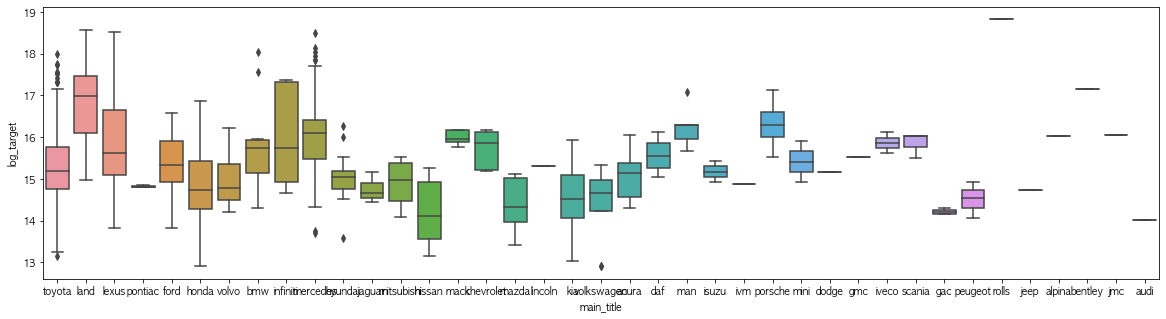

In [77]:
plt.figure(figsize = (20, 5))

sns.boxplot(x = "main_title", y = "log_target", data = origin_train)

In [ ]:
## <sp>

In [73]:
origin_train["main_title"].unique()

array(['toyota', 'land', 'lexus', 'pontiac', 'ford', 'honda', 'volvo',
       'bmw', 'infiniti', 'mercedes', 'hyundai', 'jaguar', 'mitsubishi',
       'nissan', 'mack', 'chevrolet', 'mazda', 'lincoln', 'kia',
       'volkswagen', 'acura', 'daf', 'man', 'isuzu', 'ivm', 'porsche',
       'mini', 'dodge', 'gmc', 'iveco', 'scania', 'gac', 'peugeot',
       'rolls', 'jeep', 'alpina', 'bentley', 'jmc', 'audi'], dtype=object)

In [50]:
origin_test[origin_test["year"] == 2626]

,id,title,odometer,location,isimported,engine,transmission,fuel,paint,year,main_title,log_odometer,loc
406,406,Mercedes-Benz DUMP TRUCK,0,Lagos,Locally used,V8,manual,diesel,white,2626,mercedes,0.0,lagos


In [70]:
origin_train[origin_train["main_title"] == "mercedes"]["year"].value_counts().head(1).index.values

array([2016])

In [42]:
np.unique(origin_train[origin_train["main_title"] == "mercedes"]["year"])

array([1217, 1218, 1998, 2001, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
       2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020])

In [51]:
origin_train["paint"].value_counts().head(20)

Black        292
White        115
Silver       103
Grey          84
Blue          70
Red           53
Dark Grey     47
Gold          37
white         26
Green         18
Gray          17
Brown         16
Black         15
Dark Blue     14
Wine           8
Silver         5
Sliver         5
blue           5
red            5
Grey           3
Name: paint, dtype: int64

In [125]:
np.unique(origin_train["isimported"])

array(['Foreign Used', 'Locally used', 'New '], dtype=object)

In [134]:
np.unique(origin_train["paint"].apply(lambda x: x.replace(" ", "").lower()))

array(['ash', 'ashandblack', 'beige', 'black', 'black.', 'black/red',
       'blackandsilver', 'blacksandpearl', 'blue', 'brown', 'cream',
       'darkash', 'darkblue', 'darkgray', 'darkgreen', 'darkgrey',
       'darksilver', 'deepblue', 'gery', 'gold', 'gray', 'green', 'grey',
       'inkblue', 'lightblue', 'lightgold', 'lightsilver', 'magneticgray',
       'magneticgraymetallic', 'maroon', 'midnightblackmetal', 'milk',
       'navyblue', 'offwhite', 'offwhitel', 'orange', 'palebrown',
       'purple', 'red', 'redl', 'silver', 'silver/grey', 'skyblue',
       'skyeblue', 'sliver', 'superwhite', 'whine', 'white', 'white-blue',
       'whiteorchildpearl', 'wine', 'yellow'], dtype=object)

In [37]:
origin_train["year"].unique()

array([2016, 2019, 2012, 2007, 2010, 2004, 2008, 2018, 2009, 2013, 1996,
       2014, 2002, 2006, 2017, 1998, 2011, 2005, 2000, 2015, 2001, 1995,
       2003, 1999, 1985, 2020, 1994, 1991, 1218, 1982, 1997, 1217, 1980])

In [38]:
origin_test["year"].unique()

array([2017, 2013, 2012, 2001, 2000, 2003, 2006, 2020, 2016, 2011, 2010,
       2008, 2007, 1997, 2009, 2004, 2014, 2002, 1998, 2018, 2019, 2015,
       1993, 2005, 1996, 1994, 1999, 1987, 1324, 2626, 1726])

<AxesSubplot:xlabel='year', ylabel='log_target'>

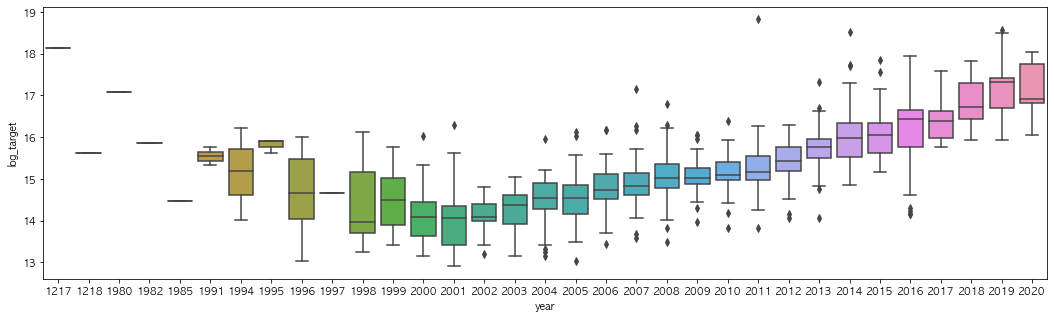

In [40]:
plt.figure(figsize = (18, 5))
sns.boxplot(x = "year", y = "log_target", data = origin_train)

In [42]:
origin_train["year"].value_counts().sort_index()

1217     1
1218     1
1980     1
1982     1
1985     1
1991     2
1994     3
1995     3
1996     7
1997     1
1998     5
1999    10
2000    12
2001    21
2002    17
2003    34
2004    36
2005    44
2006    56
2007    68
2008    82
2009    57
2010    71
2011    59
2012    56
2013    73
2014    68
2015    45
2016    70
2017    29
2018    47
2019    17
2020    17
Name: year, dtype: int64

In [43]:
origin_test["year"].value_counts().sort_index()

1324     1
1726     1
1987     1
1993     1
1994     1
1996     1
1997     3
1998     4
1999     3
2000     7
2001    11
2002     9
2003    17
2004    20
2005    17
2006    25
2007    25
2008    23
2009    32
2010    25
2011    36
2012    24
2013    23
2014    20
2015    28
2016    21
2017    16
2018    18
2019    14
2020     8
2626     1
Name: year, dtype: int64